# Code used in Meisler, Gabrieli, and Christodoulou 2024 to prepare data frame

In [10]:
# Import packages
import os
import os.path as op
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy
from glob import glob
from sklearn import preprocessing
import warnings
import nibabel as nib

warnings.filterwarnings('ignore')

# Define tracts of interest with TRACULA naming convention
tracts = {'Left_AF':'lh.af',
          'Right_AF':'rh.af',
          'Left_ILF':'lh.ilf',
          'Right_ILF':'rh.ilf',
          'Left_CST':'lh.cst',
          'Right_CST':'rh.cst',
          'Splenium':'cc.splenium'}

## Prepare phenotypic data in dataframe

In [11]:
# Define important paths
bids = '/om4/group/gablab/data/START/' # BIDS root goes here
tracula_dir = op.join(bids,'derivatives','tracula','tracts') # Where TRACULA subject output folders live
freesurfer_dir = op.join(bids,'derivatives','tracula','freesurfer') # Where FreeSurfer subject output folders live

# Get subject names
subjects = [sub.split('/')[-1] for sub in glob(op.join(tracula_dir,'sub-*')) if 'ses' not in sub]
subjects.sort()

# Define phenotypic labels of interest (names come from associated phenotype CSV file)
demo_keys = ['Age_Pre_months', 'Age_Post_months','Gender', 'Handedness', 'Dx ADHD', 'SES_Average_Education_BSMSS']
group_keys = ['GROUP 1 dys_TX;\n2 dys_noTX;\n3 dys_TX_site2;\n4 typical;\n5 other']
group_key = group_keys[0]
score_keys = ['SWE2raw', 'SWE2ss','PDE2raw', 'PDE2ss',
              'SWE2Braw_POST', 'SWE2Bss_POST', 'PDE2Braw_POST', 'PDE2Bss_POST',
              'W3WIraw', 'W3WIss', 'W3WAraw', 'W3WAss',
              'WBWIraw_POST', 'WBWIss_POST', 'WBWAraw_POST', 'WBWAss_POST',
             'SIT1raw', 'SIT1ss', 'SIT1raw_POST', 'SIT1ss_POST',
             'DIBELS_NWFraw', 'DIBELS_ORFraw ', 'DIBNraw_POST_POST','DIBOraw_POST_POST', 'KBIT2Mss']
pheno_keys = demo_keys + group_keys + score_keys  # get names of all phenotypic keys to get from CSV

# map subject naming conventions between phenotypic file and BIDS ID
# E.g., sub-START001 in BIDS is equivalent to START_001 in the phenotypic CSV
subjects_pheno_format = np.asarray([sub.replace('sub-','').replace('RT','RT_') for sub in subjects])

# Load phenotypic data of interest
df = pd.read_csv('start_phenotype.csv')
df = df.set_index('START')
# Retain only subjects with TRACULA data
df = df.loc[subjects_pheno_format][pheno_keys]
df['subjects'] = subjects
df = df.set_index('subjects')

# Remove subjects with missing scores
for sub in subjects:
    if sum(np.isnan(df[score_keys].loc[sub]))>0:
        subjects.remove(sub)
df = df.loc[subjects]

# Rename columns for style
df = df.rename(columns={"Age_Pre_months":"Age_pre", "Age_Post_months":"Age_post", "Gender":"Sex",
                       "Dx ADHD": "ADHD", 'SES_Average_Education_BSMSS':'SES',
                       "SWE2raw":"SWE2_raw_pre", "SWE2ss":"SWE2_ss_pre", "PDE2raw":"PDE2_raw_pre",
                       "PDE2ss":"PDE2_ss_pre", "SWE2Braw_POST":"SWE2_raw_post",
                       "SWE2Bss_POST":"SWE2_ss_post", "PDE2Braw_POST":"PDE2_raw_post",
                       "PDE2Bss_POST":"PDE2_ss_post", "W3WIraw":"W3WI_raw_pre",
                       "W3WIss":"W3WI_ss_pre", "W3WAraw":"W3WA_raw_pre",
                       "W3WAss":"W3WA_ss_pre",
                       "WBWIraw_POST":"W3WI_raw_post",
                       "WBWIss_POST":"W3WI_ss_post", "WBWAraw_POST":"W3WA_raw_post",
                       "WBWAss_POST":"W3WA_ss_post",
                       "GROUP 1 dys_TX;\n2 dys_noTX;\n3 dys_TX_site2;\n4 typical;\n5 other":"Group",
                       "SIT1raw":"SIT_raw_pre", "SIT1raw_POST":"SIT_raw_post",
                       "SIT1ss":"SIT_ss_pre", "SIT1ss_POST":"SIT_ss_post",
                       'DIBELS_NWFraw':'DIBELS_NWF_raw_pre', 'DIBELS_ORFraw ':'DIBELS_ORF_raw_pre', 
                       'DIBNraw_POST_POST':'DIBELS_NWF_raw_post','DIBOraw_POST_POST':'DIBELS_ORF_raw_post'})

# Add age difference column
df['Age_diff'] = df['Age_pre'] - df['Age_post']

# Binarize whether participant received intervention
group_binary = ['N' if grp==2 else 'Y' for grp in df['Group']]
df.insert(int(np.where(df.keys()=='Group')[0][0])+1, 'Intervention', group_binary)

# Code ADHD as Yes/No, instead of 0/1
df['ADHD'] = ['Y' if dx==1 else 'N' for dx in df['ADHD']]

# Calculate composite reading indices at each time point (average of four test measures)
score_key_prefixes = ['SWE2','PDE2','W3WI','W3WA'] # First two are TOWRE scores, last two are WRMT3
sessions = ['pre','post']
for scoretype in ["raw","ss"]:
    for session in sessions:
        # Get score keys for that session and raw/standard score
        score_key_session_type = [f"{prefix}_{scoretype}_{session}" for prefix in score_key_prefixes]
        # Calculate average score within subjects
        composite_score_session_type = df[score_key_session_type].mean(axis=1)
        # Add to dataframe
        df[f"Composite_Score_{scoretype}_{session}"] = composite_score_session_type


# Add difference scores and responder statuses (binary did/did not improve) for tests
tests = ['SIT', 'Composite_Score']
scoretypes = ['raw','ss']
for test in tests:
    for scoretype in scoretypes:
        df[f'{test}_{scoretype}_diff'] = df[f'{test}_{scoretype}_post'] - df[f'{test}_{scoretype}_pre']
        df[f'{test}_{scoretype}_responder'] = ['Y' if score > 0 else 'N' for score in df[f"{test}_{scoretype}_post"]-df[f"{test}_{scoretype}_pre"]]

# Needed for plotting things later        
df['All']=['All' for i in range(len(df))]

## Add neuroimaging data to dataframe

SESSION: pre
sub-START001 TMI: 163.3689220306377


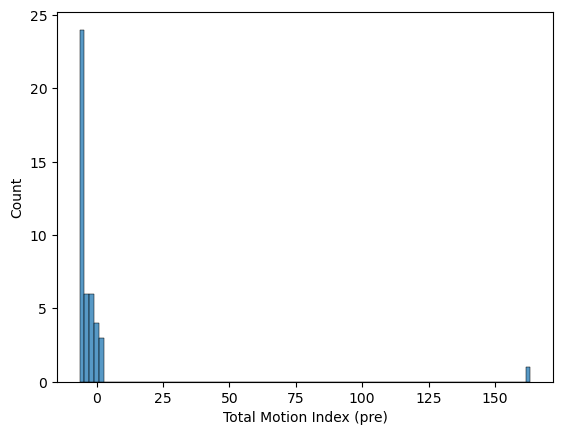

SESSION: post
sub-START013 TMI: 52.233111178435706
sub-START033 TMI: 49.39507980574544


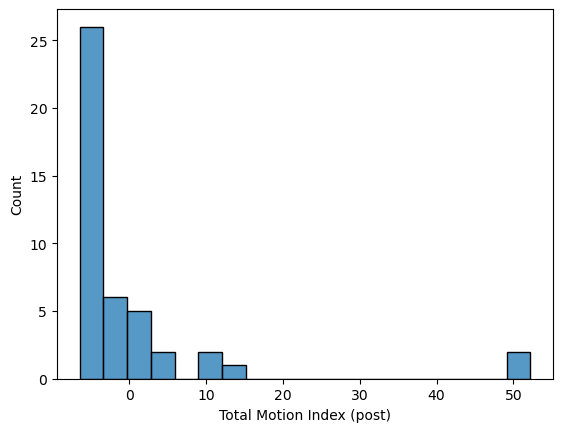

In [12]:
# Define convenience functions to get QC scores
def get_qc_scores(sub,ses):
    # 'sub' = subject name as sting (e.g., "sub-START001")
    # 'ses' = session name as string (e.g., "pre" or "post")
    path_to_qc = op.join(tracula_dir,f'{sub}_ses-{ses}.long.{sub}','dmri','dwi_motion.txt')
    f = open(path_to_qc, "r")
    lines = f.readlines()
    qc_stats = [float(num) for num in lines[-1].replace('\n','').split(' ')]
    # The four metrics that comprise the total motion index (TMI; Yendiki et al., 2014 - NeuroImage)
    tran = qc_stats[0]
    rot = qc_stats[1]
    bad_slice = qc_stats[2]
    dropout_score = qc_stats[3]
    return (tran,rot,bad_slice,dropout_score)

# Define convenience functions to get tract stats, intracranial volume, and whole-brain metrics
def get_tract_stats(sub,ses,tract):
    # 'sub' = subject name as sting (e.g., "sub-START001")
    # 'ses' = session name as string (e.g., "pre" or "post")
    # 'tract' = TRACULA tract name as string (e.g., "lh.af")
    path_to_stats = op.join(tracula_dir,f'{sub}_ses-{ses}.long.{sub}','dpath',
                            tract+'_avg16_syn_bbr','pathstats.overall.txt')
    f = open(path_to_stats, "r")
    lines = f.readlines()
    fa_avg_center = float(lines[-1].split(' ')[-1].replace('\n',''))
    md_avg_center = float(lines[-4].split(' ')[-1].replace('\n',''))
    rd_avg_center = float(lines[-7].split(' ')[-1].replace('\n',''))
    ad_avg_center = float(lines[-10].split(' ')[-1].replace('\n',''))
    return (fa_avg_center,md_avg_center,rd_avg_center,ad_avg_center)

def get_icv(sub):
    # 'sub' = subject name as sting (e.g., "sub-START001")
    path_to_stats = op.join(freesurfer_dir,sub,'stats','aseg.stats')
    f = open(path_to_stats, "r")
    lines = f.readlines()
    icv_line = [line for line in lines if 'EstimatedTotalIntraCranialVol' in line][0]
    icv = float(icv_line.split(',')[-2])
    return icv

def get_wholebrain_stats(sub,ses,metric):
    # 'sub' = subject name as sting (e.g., "sub-START001")
    # 'ses' = session name as string (e.g., "pre" or "post")
    # 'metric' = metric name as in "dtifit_XX" output convention (e.g., "FA, MD")
    path_to_metric_img = op.join(tracula_dir,f'{sub}_ses-{ses}.long.{sub}','dmri',f'dtifit_{metric}.nii.gz')
    path_to_white_matter_mask = op.join(tracula_dir,f'{sub}_ses-{ses}.long.{sub}','dlabel','diff','White-Matter.bbr.nii.gz')
    metric_img = nib.load(path_to_metric_img)
    metric_data = metric_img.get_fdata()
    mask_img = nib.load(path_to_white_matter_mask)
    mask_data = mask_img.get_fdata()
    metric_data_masked = metric_data[mask_data==1]
    metric_avg = np.mean(metric_data_masked)
    return metric_avg

# Define metrics of interest
metrics = ['FA', 'MD', 'RD', 'AD']

# Populate dataframe
df['ICV'] = np.transpose([get_icv(sub) for sub in subjects])

for session in sessions:
    # Add QC scores to dataframe
    [df[f'trans_{session}'],df[f'rot_{session}'],
     df[f'bad_slices_{session}'],df[f'dropout_score_{session}']] = np.transpose(
        [get_qc_scores(sub,session) for sub in subjects])
    
    # Add whole-brain metrics to dataframe
    for metric in ["FA","MD"]:
        df[f'wholebrain_{metric}_{session}'] = np.transpose(
            [get_wholebrain_stats(sub,session,metric) for sub in subjects])
             
    # Add tract stats to dataframe
    for tract in tracts:
        tracula_name = tracts[tract]
        [df[f"{tract}_FA_{session}"], df[f"{tract}_MD_{session}"], df[f"{tract}_RD_{session}"], df[f"{tract}_AD_{session}"]] = np.transpose(
        [get_tract_stats(sub,session,tracula_name) for sub in subjects])

# Get pre-post difference and average of tract stats
for metric in metrics:
    for tract in tracts:
        df[f"{tract}_{metric}_diff"] = df[f"{tract}_{metric}_post"] - df[f"{tract}_{metric}_pre"]
        df[f"{tract}_{metric}_avg"] = df[[f"{tract}_{metric}_post",f"{tract}_{metric}_pre"]].mean(axis=1)
        
# Get pre-post difference in whole-brain metrics
for metric in ["FA","MD"]:
    df[f"wholebrain_{metric}_diff"] = df[f"wholebrain_{metric}_post"] - df[f"wholebrain_{metric}_pre"]
    
# Add laterialization scores for tract and whole-brain metrics
tracts_to_lateralize = np.unique([key.replace("Left_","") for key in list(tracts.keys()) if "Left" in key])
for metric in metrics:
    for tract in tracts_to_lateralize:
        for session in sessions:
            left = df[f"Left_{tract}_{metric}_{session}"]
            right = df[f"Right_{tract}_{metric}_{session}"]
            lateralization = (left - right)/(left + right)
            df[f"Latscore_{tract}_{metric}_{session}"] = lateralization
        df[f"Latscore_{tract}_{metric}_diff"] = df[f"Latscore_{tract}_{metric}_post"] - df[f"Latscore_{tract}_{metric}_pre"]


motion_metrics = ['trans', 'rot', 'bad_slices', 'dropout_score']
# Get means and upper/lower quartiles of motion metrics
means = [np.mean(list(df[f"{metric}_{sessions[0]}"]) + list(df[f"{metric}_{sessions[1]}"])) for metric in motion_metrics]
upper_quarts = [np.quantile(list(df[f"{metric}_{sessions[0]}"]) + 
                            list(df[f"{metric}_{sessions[1]}"]),.75) for metric in motion_metrics]
lower_quarts = [np.quantile(list(df[f"{metric}_{sessions[0]}"]) + 
                            list(df[f"{metric}_{sessions[1]}"]),.25) for metric in motion_metrics]
for session in sessions:
    print(f"SESSION: {session}")
    TMIs = []
    # Calculate TMI following Yendiki et al., 2014
    for row in df.iterrows():
        TMI=0
        for index,metric in enumerate(motion_metrics):
            TMI_iter = (row[1][f"{metric}_{session}"] - means[index])/(upper_quarts[index]-lower_quarts[index])
            TMI+=TMI_iter
        # Print subjects with high TMI
        if TMI>20: print(row[0], 'TMI:',TMI)
        TMIs.append(TMI)
    # Add to dataframe
    df[f'TMI_{session}'] = TMIs
    # Plot histogram of TMIs
    sns.histplot(TMIs)
    plt.xlabel(f'Total Motion Index ({session})')
    plt.show()
    df[f'TMI_{session}'] = TMIs

# Remove high motion data
TMI_thresh = 20
subjects_good_TMI = np.logical_and(df['TMI_pre']<TMI_thresh,df['TMI_post']<TMI_thresh)
df = df[subjects_good_TMI]

# Save out dataframe to savetime
df.to_csv('df.csv')